In [40]:
from ising_model import ClassicIsing
import electron
from grid import Grid, HoleGrid, Mobius, Cylinder, Torus
import matplotlib.pyplot as plt
import numpy as np

In [41]:

def B_vs_T(ising_type, grid_type, temps, eq_steps, mc_steps, runs_per_T):
    average_mag = []
    for T in temps:
        total_mag = 0
        for run in range(runs_per_T):
        
            newGrid = grid_type(n_x=15, n_y=15, gridPointObject=electron.ClassicElectron, random_seed=12)
            isingModel = ising_type(newGrid, temperature=T, ferromagnetivity= 1, Mf_External=1)
            isingModel.runSimulation(eq_steps)
            mag = isingModel.magnetization()
            total_mag += mag

        print(f"T={T:.2f}, <|M|>={total_mag/runs_per_T:.3f}")

        average_mag.append(total_mag/runs_per_T)


            

    return average_mag


T=0.10, <|M|>=1.000
T=0.22, <|M|>=1.000
T=0.33, <|M|>=1.000
T=0.45, <|M|>=1.000
T=0.57, <|M|>=1.000
T=0.69, <|M|>=1.000
T=0.80, <|M|>=0.991
T=0.92, <|M|>=0.991
T=1.04, <|M|>=0.991
T=1.16, <|M|>=0.982
T=1.27, <|M|>=0.973
T=1.39, <|M|>=0.982
T=1.51, <|M|>=0.964
T=1.62, <|M|>=0.947
T=1.74, <|M|>=0.840
T=1.86, <|M|>=0.813
T=1.98, <|M|>=0.876
T=2.09, <|M|>=0.840
T=2.21, <|M|>=0.716
T=2.33, <|M|>=0.653
T=2.44, <|M|>=0.662
T=2.56, <|M|>=0.609
T=2.68, <|M|>=0.653
T=2.80, <|M|>=0.671
T=2.91, <|M|>=0.680
T=3.03, <|M|>=0.600
T=3.15, <|M|>=0.431
T=3.27, <|M|>=0.618
T=3.38, <|M|>=0.351
T=3.50, <|M|>=0.324


/var/folders/3x/y4c80np166bb8ng4y4yx6zkr0000gn/T/ipykernel_14272/2182858649.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


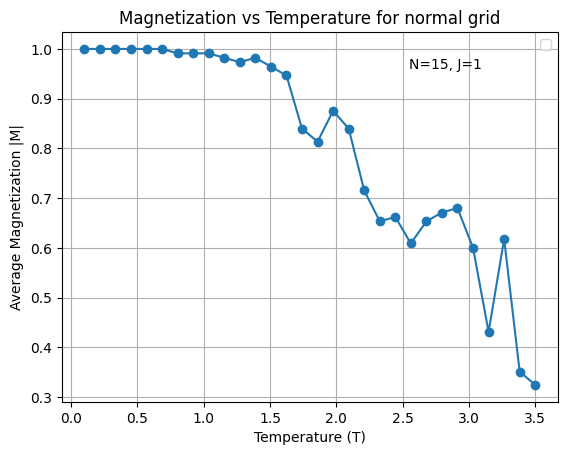

In [42]:
# --- Parameters ---
N = 15            # Lattice size
J = 1          # Coupling constant
temps = np.linspace(0.1, 3.5, 30)  # Temperature range
eq_steps = 30  # Steps for equilibration
mc_steps = 25  # Steps for measurement
runs_per_T = 10    # Average over multiple runs



mags = B_vs_T(ClassicIsing, Grid, temps, eq_steps, mc_steps, runs_per_T)


# graphing the results
plt.plot(temps, mags, marker='o')
plt.xlabel('Temperature (T)')
plt.ylabel('Average Magnetization |M|')
plt.title('Magnetization vs Temperature for normal grid')
plt.text(0.7, 0.9, f'N={N}, J={J}', transform=plt.gca().transAxes)
plt.legend()
plt.grid()
plt.show()